<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Dysk_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Etapa 1. Visualización de la data

En esta etapa nos hacemos una idea de como es la distribución de la data. Entre que valores fluctua,  en el caso de las series de tiempo univariadas, es natural realizar Boxplots y graficos de tiempo. Las librerías tipicas que utilizaremos en esta etapa son: `pandas`, `matplotlib`, `numpy` y `seaborn`.


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Dropout, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, AveragePooling1D
from keras.optimizers import SGD
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

import scikitplot
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_cumulative_gain, plot_precision_recall, plot_lift_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#set current working directory
path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(path)

In [ ]:
#Read the dataset into a pandas.DataFrame
df = pd.read_csv(path + 'CollectedSpectra.csv')

In [ ]:
df.head()

,x0,x0_5,x1,x1_5,x2,x2_5,x3,x3_5,x4,x4_5,...,x149,x149_5,x150,AIMS,Acc,Session,Drug,taxis,Hemi,State
0,0.000000,0.500000,1.000000,1.500000,2.000000,2.500000,3.000000,3.500000,4.000000,4.500000,...,149.000000,149.500000,150.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.195481,0.172190,0.141562,0.098016,0.058220,0.049786,0.138797,0.355719,0.617069,0.752140,...,-0.320252,-0.228820,-0.220877,0.0,0.015433,73.0,1.0,-32.666667,1.0,NaN
2,0.246828,0.216197,0.167901,0.091151,0.021224,0.021059,0.142704,0.395389,0.696528,0.886301,...,-0.412797,-0.321714,-0.309291,0.0,0.042097,73.0,1.0,-32.600000,1.0,NaN
3,0.345125,0.306945,0.235543,0.108845,-0.016644,-0.015601,0.152795,0.442013,0.769149,1.028015,...,-0.497198,-0.467572,-0.466961,0.0,0.044436,73.0,1.0,-32.533333,1.0,NaN
4,0.443625,0.418418,0.339642,0.157835,-0.075947,-0.119653,0.121190,0.519734,0.909909,1.193738,...,-0.472310,-0.482261,-0.480538,0.0,0.034026,73.0,1.0,-32.466667,1.0,NaN


In [ ]:
#make a copy:
Data = df.copy();

In [ ]:
#remove nans:
df.dropna(subset=['State'], axis=0, inplace=True);
df.reset_index(drop=True, inplace=True);

In [ ]:
#leave only right hemisphere:
df.drop(df[np.logical_and(df['State'] == 4, df.Hemi == 1)].index, inplace = True);

#update:
y = df.State.astype('category');
df.drop(['Acc', 'Hemi', 'State'], axis = 1, inplace = True);
df.reset_index(drop = True, inplace = True);


##PreProcessing:

In [ ]:
#Scale the data:

dim = df.shape
labels = [];
for ix in range(dim[1]):
  if ix > 300:
    continue;
  labels.append('x'+ str(ix));

scaler = MinMaxScaler();
dummy = df.iloc[:, range(len(labels))];
X = scaler.fit_transform(dummy)

#Save scaler:
fileoutScaler = 'scaler_model.sav';
joblib.dump(scaler, 'models/' + fileoutScaler);

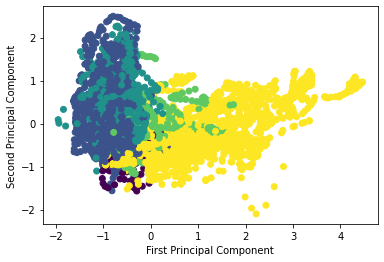

In [ ]:
#Check how does the data looks like:

import numpy as np

# Initialize PCA
pca = PCA()

# Fit the PCA model to the data
pca.fit(X)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to explain at least 80% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1

# Update the PCA model with the number of components needed to explain at least 80% of the variance
pca = PCA(n_components=n_components)
pca.fit(X)

# Perform dimensionality reduction on the data
X_reduced = pca.transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], c = y);
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

In [ ]:
num_features = len(labels);
bStates = np.unique(y);
num_classes = len(bStates);

# Define the model
input_layer = Input(shape=(num_features, 1), dtype = 'float32')  # shape of input data
conv_layer1 = Conv1D(filters=100, kernel_size= 10, activation='relu')(input_layer)
conv_layer2 = Conv1D(filters=100, kernel_size= 10, activation='relu')(conv_layer1)
pool_layer1 = MaxPooling1D(pool_size=3)(conv_layer2)
conv_layer3 = Conv1D(filters=160, kernel_size= 10, activation='relu')(pool_layer1)
conv_layer4 = Conv1D(filters=160, kernel_size= 10, activation='relu')(conv_layer3)
pool_layer2 = AveragePooling1D(pool_size=3)(conv_layer4)
dropout_layer1 = Dropout(0.5)(pool_layer2)
flatten_layer = Flatten()(dropout_layer1)
dense1 = Dense(32, activation='relu')(flatten_layer)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
dropout_layer2 = Dropout(0.2)(dense3)
output_layer = Dense(units=num_classes, activation='softmax')(dropout_layer2)  # output layer with 10 units and softmax activation

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 301, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 292, 100)          1100      
                                                                 
 conv1d_1 (Conv1D)           (None, 283, 100)          100100    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 94, 100)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 85, 160)           160160    
                                                                 
 conv1d_3 (Conv1D)           (None, 76, 160)           256160    
                                                             

In [ ]:
# Train the model
model_path = path + 'models'
save_weights_at = os.path.join(model_path, 'dysk.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)

# use 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)
scores = [];
lossxy = [];
count = 0
for train_index, test_index in kfold.split(X, y):

  X_train, X_test = X[train_index], X[test_index];
  y_train, y_test = y[train_index], y[test_index];

  taxis_train = np.array(df.taxis)[train_index,None];
  drug_train = np.array(df.taxis)[train_index,None];
  session_train = np.array(df.taxis)[train_index,None];
  taxis_test = np.array(df.taxis)[test_index,None];
  drug_test = np.array(df.taxis)[test_index,None];
  session_test = np.array(df.taxis)[test_index,None];

  # Reshape input data
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  # Convert the labels to categorical format
  y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

  history = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, shuffle=True, callbacks=[save_best], validation_data=(X_test, y_test));

  lossxy.append([history.history['loss'], history.history['val_loss']]);
  _, acc = model.evaluate(X_test, y_test, verbose=0)

  scores.append(acc)
  count = count + 1;

print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(scores)*100, np.std(scores)*100))

      

Epoch 1/20
116/116 [==============================] - 11s 21ms/step - loss: 0.9478 - accuracy: 0.6410 - val_loss: 0.6194 - val_accuracy: 0.7702
Epoch 2/20
116/116 [==============================] - 1s 8ms/step - loss: 0.6863 - accuracy: 0.7543 - val_loss: 0.6265 - val_accuracy: 0.7476
Epoch 3/20
116/116 [==============================] - 1s 8ms/step - loss: 0.6245 - accuracy: 0.7624 - val_loss: 0.6428 - val_accuracy: 0.7487
Epoch 4/20
116/116 [==============================] - 1s 9ms/step - loss: 0.6071 - accuracy: 0.7794 - val_loss: 0.5478 - val_accuracy: 0.7821
Epoch 5/20
116/116 [==============================] - 1s 8ms/step - loss: 0.5848 - accuracy: 0.7861 - val_loss: 0.5944 - val_accuracy: 0.7832
Epoch 6/20
116/116 [==============================] - 1s 9ms/step - loss: 0.5633 - accuracy: 0.7891 - val_loss: 0.4931 - val_accuracy: 0.8080
Epoch 7/20
116/116 [==============================] - 1s 9ms/step - loss: 0.5512 - accuracy: 0.7945 - val_loss: 0.4843 - val_accuracy: 0.8101
Epoc

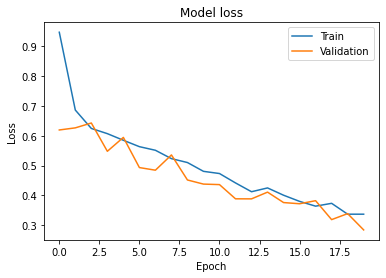

In [ ]:
# Plot the training and validation loss
plt.plot(lossxy[0][0])
plt.plot(lossxy[0][1])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right');
plt.show()

In [ ]:
# Get the index of the epoch with the lowest validation loss
min_loss_index = np.argmin(history.history['val_loss']);

# Get the best validation loss and best epoch number
best_val_loss = history.history['val_loss'][min_loss_index];
best_epoch = min_loss_index + 1;

print("Best Validation Loss: {:.4f} at epoch {}".format(best_val_loss, best_epoch));

Best Validation Loss: 0.0009 at epoch 15


In [ ]:
best_epoch = 18

In [ ]:
best_model = load_model(os.path.join(model_path, f'dysk.{best_epoch:02d}-{best_val_loss:.4f}.hdf5'));

# Get the predicted probabilities
pred_probs = best_model.predict(X_test);

# The shape of pred_probs will be (number of test samples, number of classes)
print(pred_probs.shape)

# Each row represents the predicted probabilities for a single test sample
print(pred_probs[0])

29/29 [==============================] - 0s 3ms/step
(927, 5)
[1.0000000e+00 4.4876494e-12 4.1198304e-14 7.6941005e-17 6.0030882e-16]


In [ ]:
originalStates = np.argmax(y_test, axis = 1);
predStates = np.argmax(pred_probs, axis = 1)
print(f'Original States: {np.unique(originalStates)}');
print(f'Predicted States: {np.unique(predStates)}');

Original States: [0 1 2 3 4]
Predicted States: [0 1 2 3 4]


In [ ]:
mae = mean_absolute_error(originalStates, predStates)
print(f'MAE for the validation set: {mae:.4f}')

MAE for the validation set: 0.0000


In [ ]:
r2 = r2_score(predStates, originalStates)
print('R-squared for the validation set:', round(r2,4))

R-squared for the validation set: 1.0


In [ ]:
a = pred_probs[:,0]

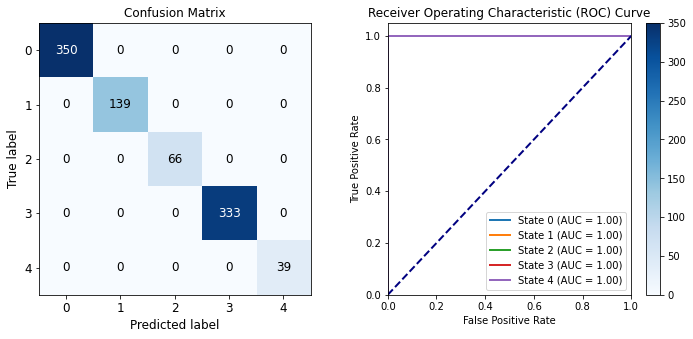

In [ ]:
# Plot the confusion matrix and the ROC curve in the same figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
plot_confusion_matrix(originalStates, predStates, title = 'Confusion Matrix',text_fontsize = 'large', 
                      title_fontsize = 'large', ax = ax[0])
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("True label")
ax[0].set_title("Confusion Matrix")

# Plot the ROC curve
bStates = np.unique(originalStates);
for k in range(len(bStates)):
  fpr, tpr, thresholds = roc_curve(originalStates == bStates[k], pred_probs[:,k]);
  roc_auc = auc(fpr, tpr)

  ax[1].plot(fpr, tpr, lw=2, label= f'State {bStates[k]} (AUC = {roc_auc:0.2f})')

ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

plt.show()